In [9]:
from transformers import AutoTokenizer, AutoModel, utils
utils.logging.set_verbosity_error()  # Suppress standard warnings
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)

In [10]:
with open("prompt.txt", "r") as file:
        large_prompt = file.read()

inputs = tokenizer.encode(large_prompt, return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 

In [ ]:
from bertviz import head_view
head_view(attention, tokens)

Top 20 tokens with highest attention:
raw: 0.4576
{: 0.0114
.: 0.0067
id: 0.0067
': 0.0063
,: 0.0062
:: 0.0062
:: 0.0060
": 0.0059
": 0.0054
[: 0.0054
": 0.0053
you: 0.0052
actions: 0.0051
raw: 0.0051
{: 0.0048
7: 0.0047
parcel: 0.0047
response: 0.0047
score: 0.0045

Bottom 20 tokens with lowest attention:
?: 0.0002
action: 0.0005
next: 0.0008
the: 0.0010
action: 0.0010
your: 0.0010
is: 0.0012
': 0.0013
just: 0.0013
any: 0.0013
ed: 0.0014
t: 0.0014
a: 0.0016
10: 0.0016
comment: 0.0017
what: 0.0017
,: 0.0018
par: 0.0018
cel: 0.0018
s: 0.0018


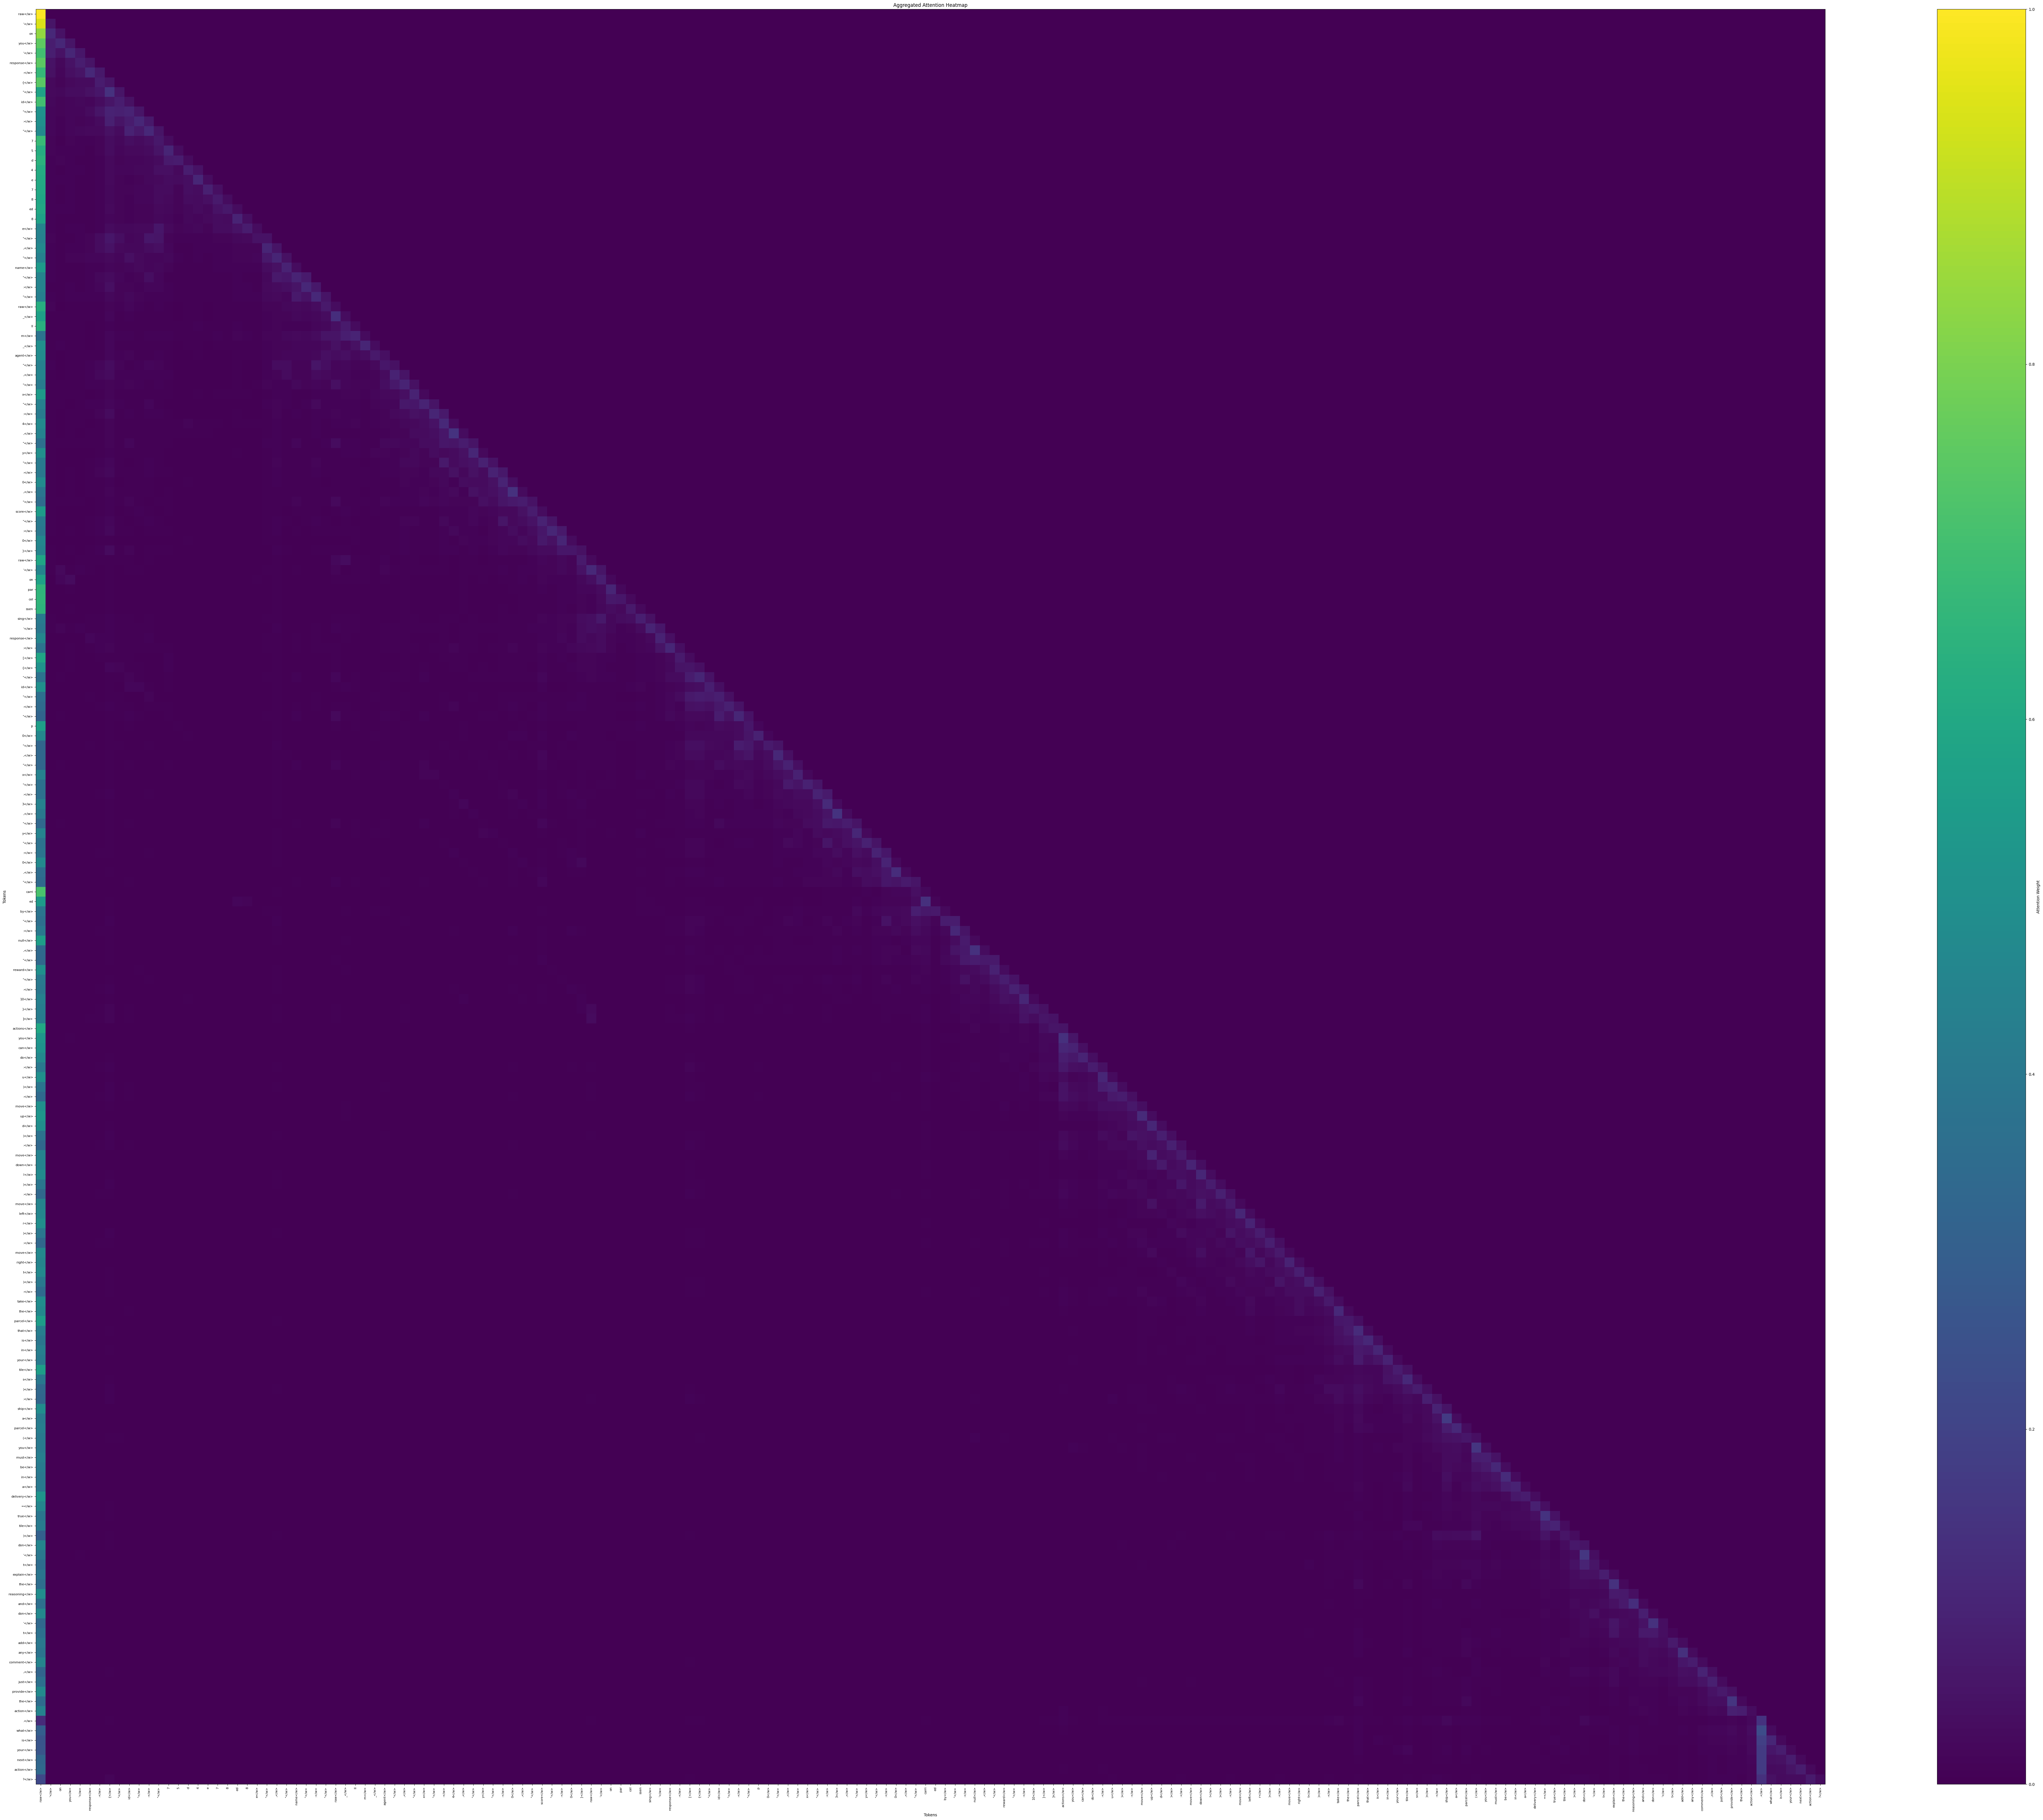

In [11]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(prompt, model_name="bert-base-uncased", top_x=20):
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, output_attentions=True)

    # Tokenize the input text
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)

    # Forward pass to get attention
    with torch.no_grad():
        outputs = model(**inputs)

    attentions = outputs.attentions  # List of attention tensors (layers, heads, seq_len, seq_len)

    # Aggregate attention across heads
    aggregated_attentions = [layer.mean(dim=1).squeeze(0).numpy() for layer in attentions]

    # Combine across all layers
    combined_attention = np.mean(aggregated_attentions, axis=0)

    # Token labels for visualization
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))

    # Calculate average attention for each token
    avg_attention = combined_attention.mean(axis=0)

    # Get top X and bottom X tokens by attention
    top_indices = np.argsort(avg_attention)[-top_x:][::-1]
    bottom_indices = np.argsort(avg_attention)[:top_x]

    top_tokens = [(tokens[i], avg_attention[i]) for i in top_indices]
    bottom_tokens = [(tokens[i], avg_attention[i]) for i in bottom_indices]

    print(f"Top {top_x} tokens with highest attention:")
    for token, attention in top_tokens:
        print(f"{token.replace("</w>", "")}: {attention:.4f}")

    print(f"\nBottom {top_x} tokens with lowest attention:")
    for token, attention in bottom_tokens:
        print(f"{token.replace("</w>", "")}: {attention:.4f}")

    # Plot attention
    plt.figure(figsize=(80, 64))  # Increase the figure size for better navigation
    plt.imshow(combined_attention, cmap="viridis", aspect="auto")
    plt.colorbar(label="Attention Weight")
    plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=8)
    plt.yticks(range(len(tokens)), tokens, fontsize=8)
    plt.title("Aggregated Attention Heatmap")
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.tight_layout()
    plt.show()

# Example usage
with open("prompt.txt", "r") as file:
        large_prompt = file.read()
visualize_attention(large_prompt, model_name="openai-gpt")
